<h3>Bollinger Bands && RSI Strategy</h3>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api import TimeFrame
import pandas as pd
import numpy as np
import quantstats as qs

In [3]:
# API Credentials
API_KEY=""
SECRET_KEY=""
endpoint = "https://paper-api.alpaca.markets"

api = tradeapi.REST(API_KEY, SECRET_KEY, endpoint, api_version='v2')

In [4]:
symbol = 'AAPL'
timeframe = TimeFrame.Hour
start_date = "2022-01-01"
end_date = "2022-01-31"

In [5]:
barset = {}
barset[symbol] = api.get_bars(symbol, timeframe, start=start_date, end=end_date).df
data = barset[symbol]
data

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-01-03 09:00:00+00:00,178.26,178.34,177.76,178.08,60937,1727,177.954244
2022-01-03 10:00:00+00:00,178.08,178.22,177.99,178.17,45629,887,178.121076
2022-01-03 11:00:00+00:00,178.17,178.46,178.16,178.45,39121,1189,178.337821
2022-01-03 12:00:00+00:00,178.46,178.50,178.09,178.25,184199,2743,178.272343
2022-01-03 13:00:00+00:00,178.25,178.45,177.57,177.65,359954,5117,178.086768
...,...,...,...,...,...,...,...
2022-01-31 20:00:00+00:00,173.49,175.00,172.77,174.80,21869271,190486,174.032987
2022-01-31 21:00:00+00:00,174.66,174.96,174.20,174.35,17330898,5281,174.756620
2022-01-31 22:00:00+00:00,174.35,174.40,174.05,174.17,109389,1698,174.267698


In [6]:
def calculate_bollinger_bands(data, window=20, std_dev=2):
    rolling_mean = data['close'].rolling(window).mean()
    rolling_std = data['close'].rolling(window).std()
    data['bb_upper'] = rolling_mean + (rolling_std * std_dev)
    data['bb_lower'] = rolling_mean - (rolling_std * std_dev)
    return data

def calculate_rsi(data, window=20):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['rsi'] = rsi
    return data

                           Strategy
-------------------------  ----------
Start Period               2022-01-03
End Period                 2022-02-01
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -2.07%
CAGR﹪                     -17.13%

Sharpe                     -0.13
Prob. Sharpe Ratio         44.16%
Smart Sharpe               -0.13
Sortino                    -0.21
Smart Sortino              -0.2
Sortino/√2                 -0.15
Smart Sortino/√2           -0.14
Omega                      0.98

Max Drawdown               -14.37%
Longest DD Days            28
Volatility (ann.)          9.27%
Calmar                     -1.19
Skew                       1.31
Kurtosis                   7.36

Expected Daily %           -0.01%
Expected Monthly %         -1.04%
Expected Yearly %          -2.07%
Kelly Criterion            -1.22%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.97%
Expected Shortfall (cVaR)  -0.97%

Max Consecutive W

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-04,2022-01-24,2022-02-01,28,-14.365997,-14.000436
2,2022-01-03,2022-01-03,2022-01-03,1,-0.448305,-0.112076
3,2022-01-03,2022-01-03,2022-01-04,1,-0.265950,-0.249500


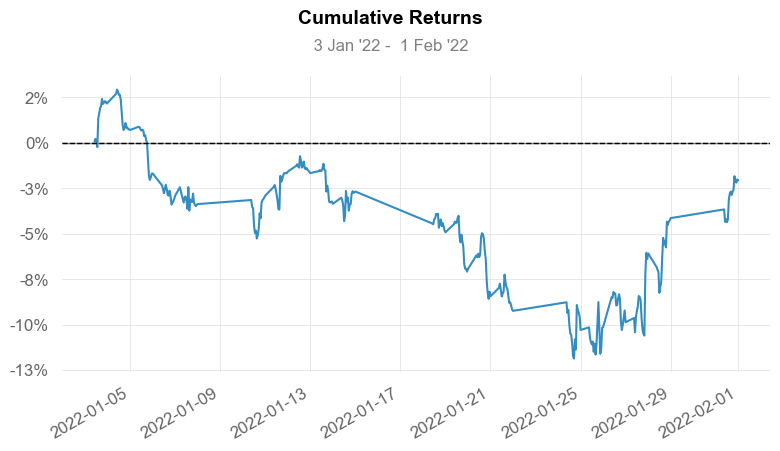

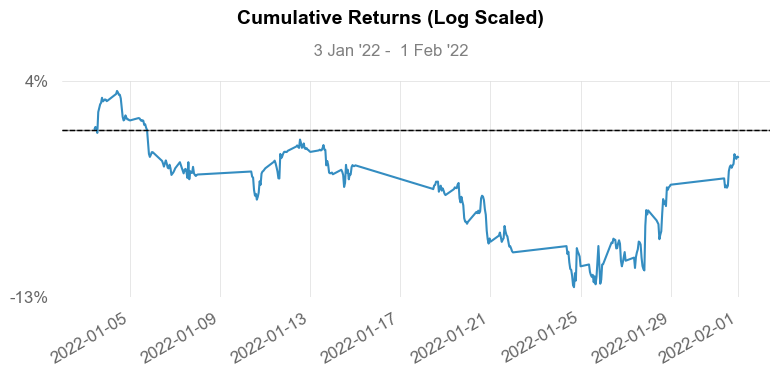

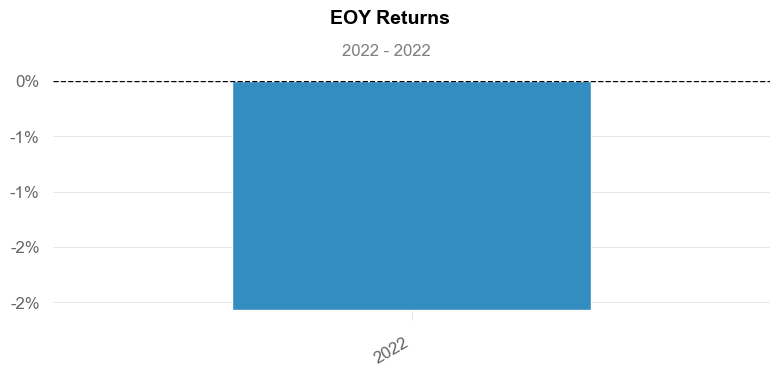

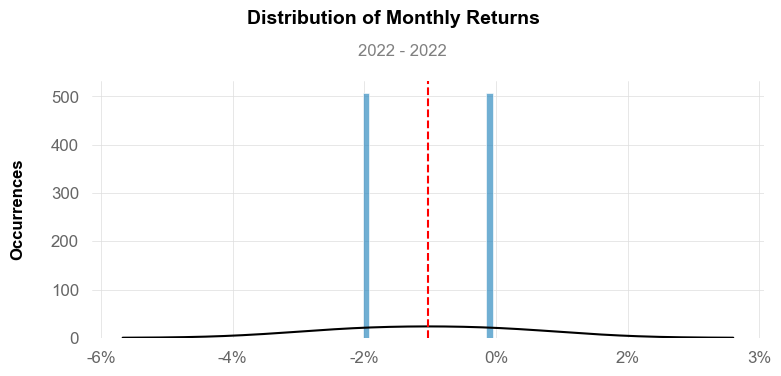

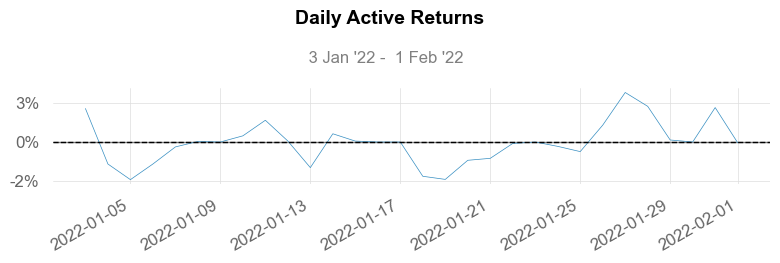

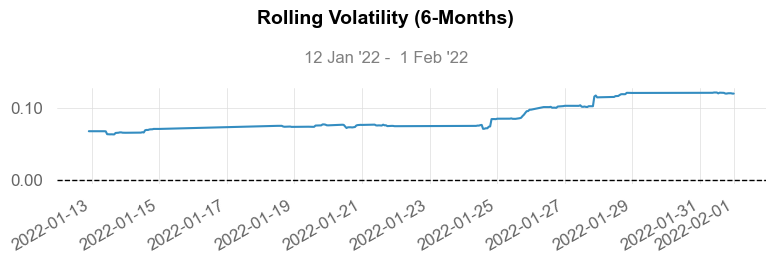

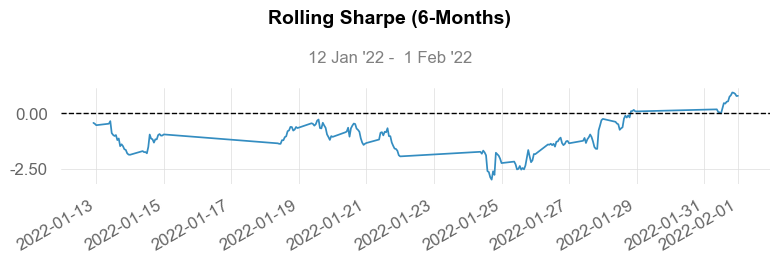

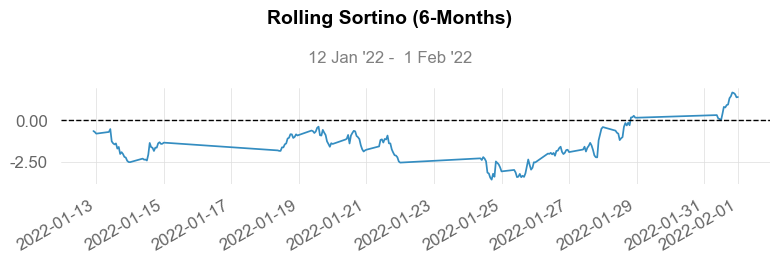

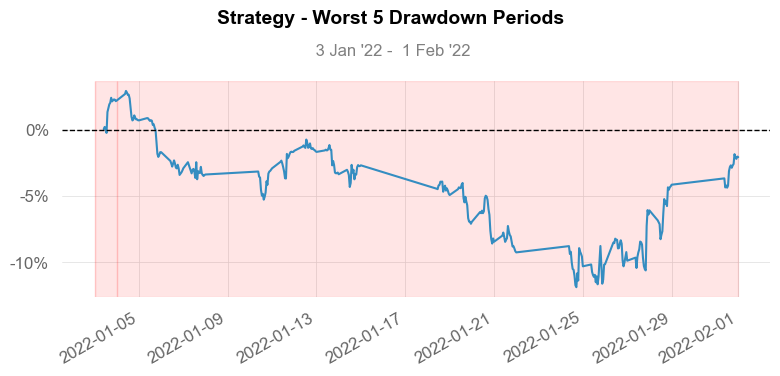

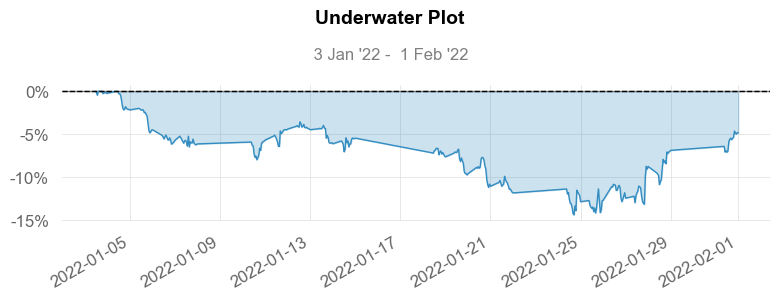

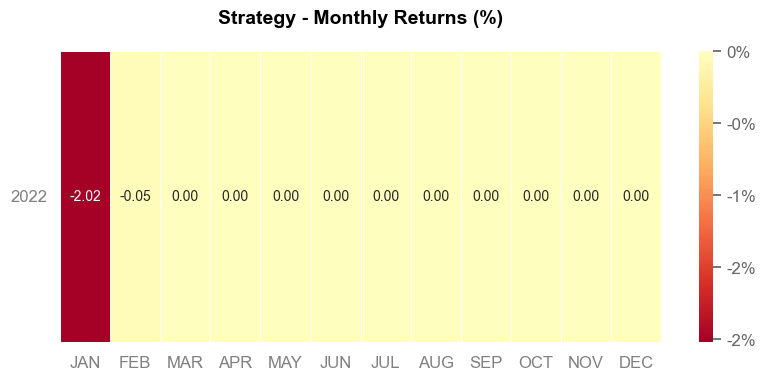

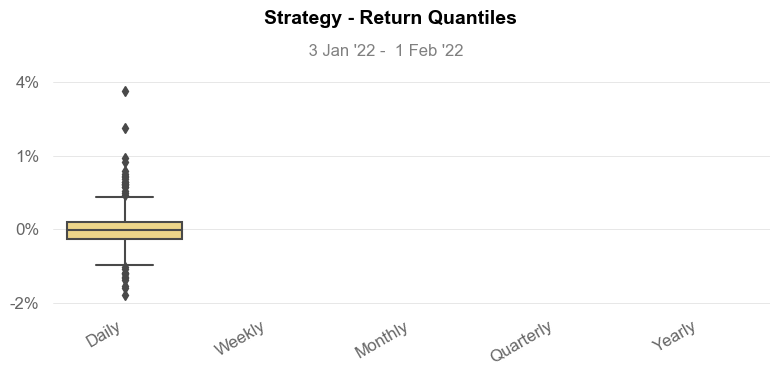

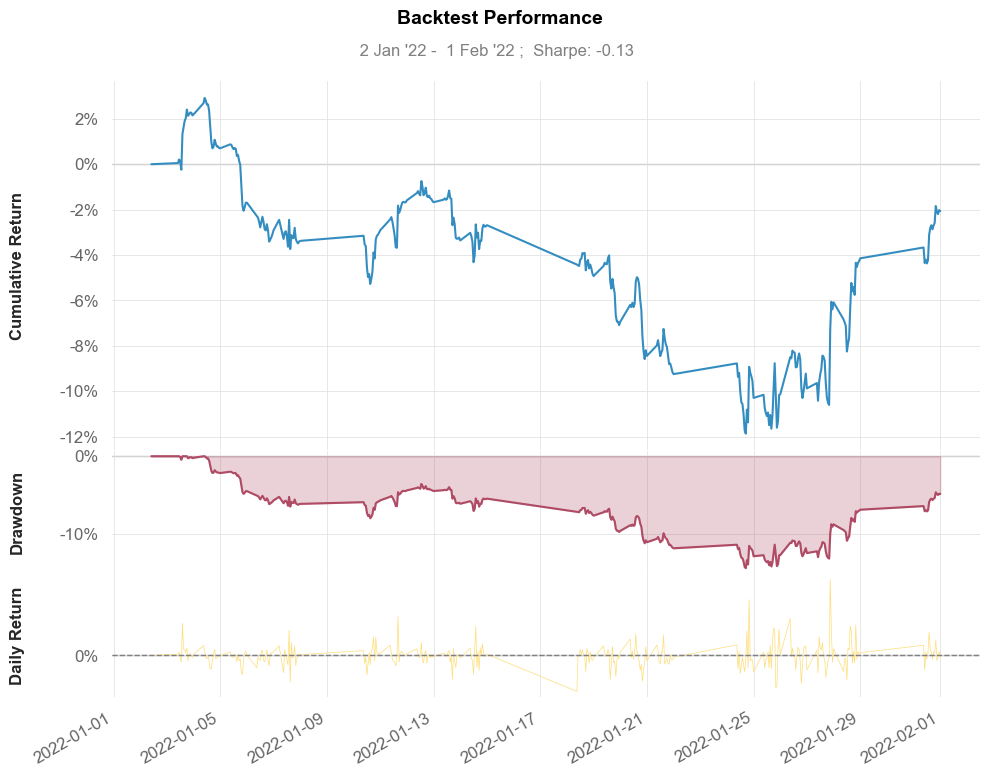

In [7]:
# Perform initial calculations
stock_data = calculate_bollinger_bands(data)
stock_data = calculate_rsi(data)

# Initialize 'position' column with zeros
stock_data['position'] = 0

# Define the buy and sell signals based on the conditions
stock_data.loc[(stock_data['close'] < stock_data['bb_lower']) & (stock_data['rsi'] < 30) & (stock_data['position'] == 0), 'buy_signal'] = 1
stock_data.loc[(stock_data['close'] > stock_data['bb_upper']) & (stock_data['rsi'] > 70) & (stock_data['position'] == 1), 'sell_signal'] = -1

# Forward fill the signals to capture the entire holding period
stock_data['buy_signal'].ffill(inplace=True)
stock_data['sell_signal'].ffill(inplace=True)

# Calculate position based on buy and sell signals
stock_data['position'] = stock_data['buy_signal'].cumsum() + stock_data['sell_signal'].cumsum()

# Perform backtesting using quantstats
qs.extend_pandas()
returns = pd.Series(data['close'].pct_change().dropna().values, index=pd.to_datetime(data.index[1:]).to_numpy(dtype='datetime64[ns]'))

#Convert the index to YYYY-MM-DD format
formatted_index = returns.index.strftime('%Y-%m-%d %H:00')

returns = pd.Series(returns.values, index=formatted_index)
returns.index = pd.to_datetime(returns.index)
qs.reports.full(returns)

# Plot the performance metrics
qs.plots.snapshot(returns, title='Backtest Performance')

In [8]:
def execute_order(symbol, qty, side):
    try:
        current_rsi = data['rsi'].iloc[-1]  # Get the most recent RSI value
        if current_rsi < 75:  # Adjust the threshold as per your strategy
            print(f'RSI is below 30 ({current_rsi}). Placing {side} order for {qty} shares of {symbol}.')
            api.submit_order(
                symbol=symbol,
                qty=qty,
                side=side,
                type='market',
                time_in_force='gtc'
            )
            print(f'Successfully executed {side} order for {qty} shares of {symbol}.')
        else:
            print(f'RSI is above 30 ({current_rsi}). No {side} order placed.')

    except Exception as e:
        print(f'Error executing {side} order for {qty} shares of {symbol}: {e}')

In [9]:
execute_order(symbol, 10, 'buy')
# execute_order(symbol, 1, 'sell')

RSI is below 30 (70.625260992229). Placing buy order for 10 shares of AAPL.
Successfully executed buy order for 10 shares of AAPL.
